In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, HuberRegressor, SGDRegressor
)
import lightgbm as lgb
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [27]:
df = pd.read_csv("./dataset/train_data.csv")
test_df = pd.read_csv("./dataset/test_data.csv")

In [28]:
print("Train shape")
print(df.shape)
print("Test shape")
print(test_df.shape)

Train shape
(116023, 52)
Test shape
(29006, 51)


In [29]:
df.isna().sum()

trafficSource.isTrueDirect                       73133
purchaseValue                                        0
browser                                              0
device.screenResolution                              0
trafficSource.adContent                         113060
trafficSource.keyword                            71861
screenSize                                           0
geoCluster                                           0
trafficSource.adwordsClickInfo.slot             111742
device.mobileDeviceBranding                          0
device.mobileInputSelector                           0
userId                                               0
trafficSource.campaign                               0
device.mobileDeviceMarketingName                     0
geoNetwork.networkDomain                             0
gclIdPresent                                         0
device.operatingSystemVersion                        0
sessionNumber                                        0
device.fla

In [30]:
df

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,61421,(not set),not available in demo dataset,domain1,0,not available in demo dataset,1,not available in demo dataset,Washington,youtube.com,1,not available in demo dataset,1500100799,Windows,Northern America,referral,NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Redmond,NaN,Seattle-Tacoma WA,1.0,8,not available in demo dataset,/intl/hr/yt/about/,1.0,20170714,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,72287,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,California,(direct),1,not available in demo dataset,1495262065,Macintosh,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Mountain View,NaN,San Francisco-Oakland-San Jose CA,1.0,8,not available in demo dataset,NaN,1.0,20170519,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,25180,(not set),not available in demo dataset,domain1,0,not available in demo dataset,2,not available in demo dataset,Lombardy,google,1,not available in demo dataset,1508510328,Windows,Southern Europe,organic,NaN,not available in demo dataset,Italy,not available in demo dataset,NaN,Not Socially Engaged,Milan,NaN,(not set),6.0,8,not available in demo dataset,NaN,NaN,20171020,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,41295,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,youtube.com,1,not available in demo dataset,1483431838,Windows,Eastern Asia,referral,NaN,not available in demo dataset,Japan,not available in demo dataset,NaN,Not Socially Engaged,not available in demo dataset,NaN,not available in demo dataset,1.0,8,not available in demo dataset,/yt/about/ja/,1.0,20170103,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,113697,(not set),not available in demo dataset,domain1,0,not available 

In [31]:
test_df.isna().sum()

userChannel                                         0
date                                                0
browser                                             0
device.browserSize                                  0
device.browserVersion                               0
deviceType                                          0
device.flashVersion                                 0
device.isMobile                                     0
device.language                                     0
device.mobileDeviceBranding                         0
device.mobileDeviceMarketingName                    0
device.mobileDeviceModel                            0
device.mobileInputSelector                          0
os                                                  0
device.operatingSystemVersion                       0
device.screenColors                                 0
device.screenResolution                             0
geoNetwork.city                                     0
geoNetwork.continent        

In [32]:
df.duplicated().sum()

np.int64(236)

In [33]:
test_df.duplicated().sum()

np.int64(16)

In [34]:
def clean_data(df, is_train=True):
    df = df.copy()
    # Only remove duplicates in train
    if is_train:
        df.drop_duplicates(inplace=True)
    # Handle object columns (categorical/text)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna("Unknown")
    # Handle numeric columns
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        median_val = df[col].mode()
        df[col] = df[col].fillna(median_val)
    return df


In [35]:
df = clean_data(df, True)
test_df = clean_data(test_df, False)

In [36]:
target_col = list(set(df.columns) - set(test_df.columns))
print("Target Column:", target_col)


Target Column: ['purchaseValue']


In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 115787 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    115787 non-null  object 
 1   purchaseValue                                 115787 non-null  float64
 2   browser                                       115787 non-null  object 
 3   device.screenResolution                       115787 non-null  object 
 4   trafficSource.adContent                       115787 non-null  object 
 5   trafficSource.keyword                         115787 non-null  object 
 6   screenSize                                    115787 non-null  object 
 7   geoCluster                                    115787 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           115787 non-null  object 
 9   device.mobileDeviceBranding                   115787 

In [38]:
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Constant columns:", constant_cols)
df.drop(columns=constant_cols, inplace=True)
test_df.drop(columns=constant_cols, inplace=True) 


Constant columns: ['device.screenResolution', 'screenSize', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'totals.visits', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'socialEngagementType', 'locationZone', 'device.mobileDeviceModel', 'totals.bounces', 'device.language', 'device.browserVersion', 'device.screenColors', 'new_visits']


In [39]:
# High cardinality warning
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() > 50:
        print(f"{col}: {df[col].nunique()} unique values (possibly high-cardinality)")
    else:
        print(f"{col}: {df[col].nunique()}")


trafficSource.isTrueDirect: 2
browser: 34
trafficSource.adContent: 54 unique values (possibly high-cardinality)
trafficSource.keyword: 567 unique values (possibly high-cardinality)
geoCluster: 5
trafficSource.adwordsClickInfo.slot: 4
trafficSource.campaign: 28
geoNetwork.networkDomain: 3
geoNetwork.region: 388 unique values (possibly high-cardinality)
trafficSource: 161 unique values (possibly high-cardinality)
os: 18
geoNetwork.subContinent: 23
trafficSource.medium: 7
trafficSource.adwordsClickInfo.isVideoAd: 2
locationCountry: 193 unique values (possibly high-cardinality)
trafficSource.adwordsClickInfo.adNetworkType: 3
geoNetwork.city: 695 unique values (possibly high-cardinality)
geoNetwork.metro: 104 unique values (possibly high-cardinality)
trafficSource.referralPath: 942 unique values (possibly high-cardinality)
deviceType: 3
userChannel: 8
geoNetwork.continent: 6


In [40]:
df.head(5000)

,trafficSource.isTrueDirect,purchaseValue,browser,trafficSource.adContent,trafficSource.keyword,geoCluster,trafficSource.adwordsClickInfo.slot,userId,trafficSource.campaign,geoNetwork.networkDomain,gclIdPresent,sessionNumber,geoNetwork.region,trafficSource,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,locationCountry,trafficSource.adwordsClickInfo.adNetworkType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,trafficSource.referralPath,date,deviceType,userChannel,totalHits,sessionStart,geoNetwork.continent,device.isMobile
0,Unknown,0.0,Edge,Unknown,Unknown,Region_2,Unknown,61421,(not set),domain1,0,1,Washington,youtube.com,1500100799,Windows,Northern America,referral,Unknown,United States,Unknown,Redmond,1.0,Seattle-Tacoma WA,1.0,/intl/hr/yt/about/,20170714,desktop,Social,1,1500100799,Americas,False
1,True,0.0,Chrome,Unknown,Unknown,Region_3,Unknown,72287,(not set),domain3,0,1,California,(direct),1495262065,Macintosh,Northern America,(none),Unknown,United States,Unknown,Mountain View,NaN,San Francisco-Oakland-San Jose CA,1.0,Unknown,20170519,desktop,Direct,1,1495262065,Americas,False
2,True,0.0,Chrome,Unknown,(not provided),Region_2,Unknown,25180,(not set),domain1,0,2,Lombardy,google,1508510328,Windows,Southern Europe,organic,Unknown,Italy,Unknown,Milan,NaN,(not set),6.0,Unknown,20171020,desktop,Organic Search,6,1508510328,Europe,False
3,Unknown,0.0,Internet Explorer,Unknown,Unknown,Region_4,Unknown,41295,(not set),domain3,0,1,not available in demo dataset,youtube.com,1483431838,Windows,Eastern Asia,referral,Unknown,Japan,Unknown,not available in demo dataset,NaN,not available in demo dataset,1.0,/yt/about/ja/,20170103,desktop,Social,1,1483431838,Asia,False
4,True,88950000.0,Chrome,Unknown,Unknown,Region_3,Unknown,113697,(not set),domain1,0,1,not available in demo dataset,(direct),1475804633,Windows,Northern America,(none),Unknown,United States,Unknown,not available in demo dataset,NaN,not available in demo dataset,54.0,Unknown,20161006,desktop,Direct,66,1475804633,Americas,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,Unknown,0.0,Chrome,Unknown,(not provided),Region_2,Unknown,22329,(not set),domain2,0,1,Lazio,google,1516285941,Windows,Southern Europe,organic,Unknown,Italy,Unknown,Rome,NaN,(not set),1.0,Unknown,20180118,desktop,Organic Search,1,1516285941,Europe,False
4997,True,0.0,Safari,Google Merchandise Store,(automatic matching),Region_2,RHS,67825,1000557 | GA | US | en | Hybrid | GDN Remarketing,domain2,1,2,not available in demo dataset,google,1508212153,iOS,Northern America,cpc,False,United States,Content,not available in demo dataset,1.0,not available in demo dataset,1.0,Unknown,20171016,tablet,Display,1,1508212153,Americas,True
4998,Unknown,0.0,Chrome,Unknown,Unknown,Region_4,Unknown,43957,(not set),domain2,0,1,not available in demo dataset,youtube.com,1480046029,Windows,Southeast Asia,referral,Unknown,Vietnam,Unknown,not available in demo dataset,NaN,not available in demo dataset,1.0,/yt/about/vi/,20161124,desktop,Social,1,1480046029,Asia,False
4999,True,501840000.0,Chrome,Unknown,Unknown,Region_1,Unknown,15467,(not set),domain3,0,4,not available in demo dataset,mall.googleplex.com,1484346392,Chrome OS,Northern America,referral,Unknown,United States,Unknown,not available in demo dataset,NaN,not available in demo dataset,36.0,/,20170113,desktop,Referral,42,1484346392,Americas,False


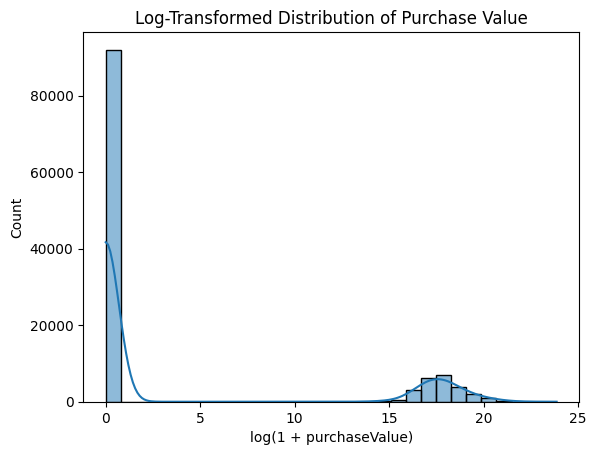

In [41]:
df['purchaseValue_log'] = np.log1p(df['purchaseValue'])
sns.histplot(df['purchaseValue_log'], bins=30, kde=True)
plt.title("Log-Transformed Distribution of Purchase Value")
plt.xlabel("log(1 + purchaseValue)")
plt.show()
df.drop('purchaseValue_log', axis=1, inplace=True)

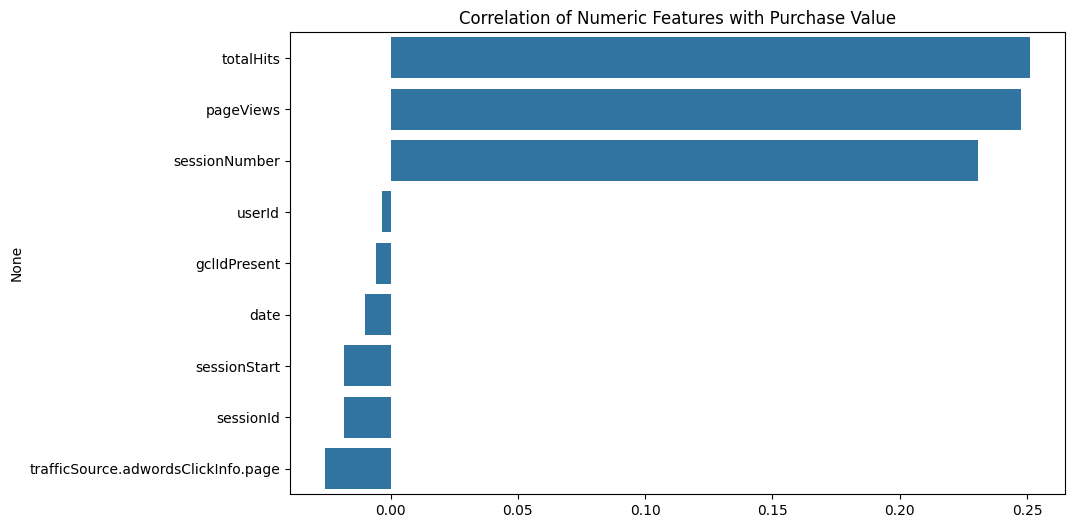

In [42]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = [col for col in num_cols if col != 'purchaseValue']
corr = df[num_cols].corrwith(df['purchaseValue']).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Numeric Features with Purchase Value")
plt.show()


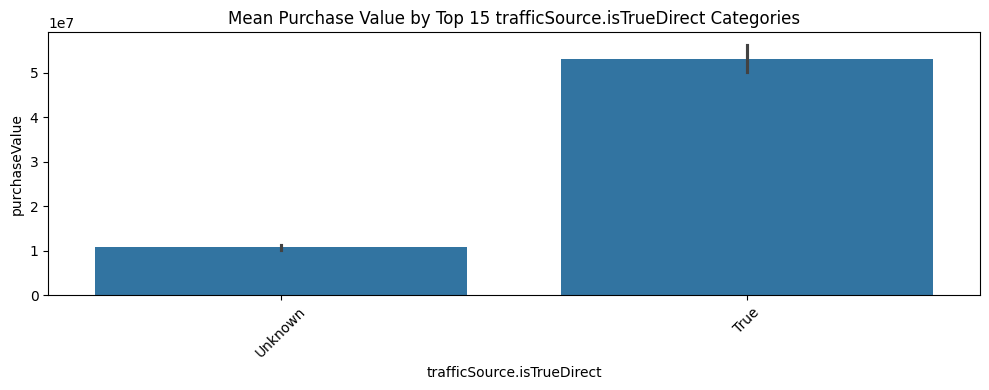

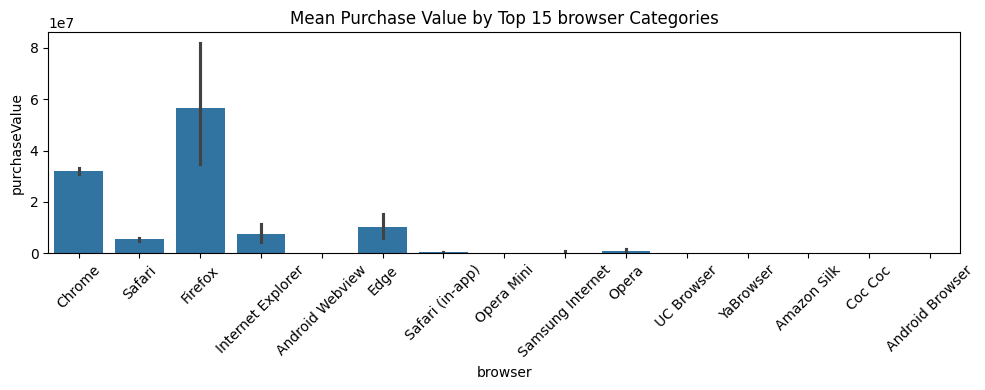

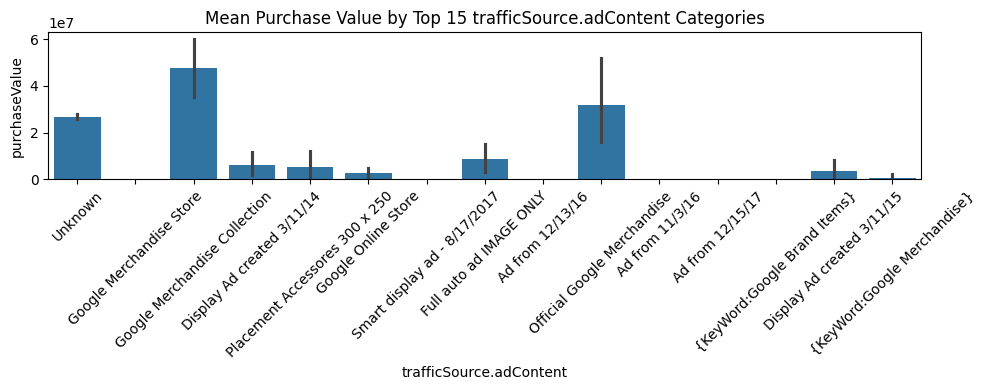

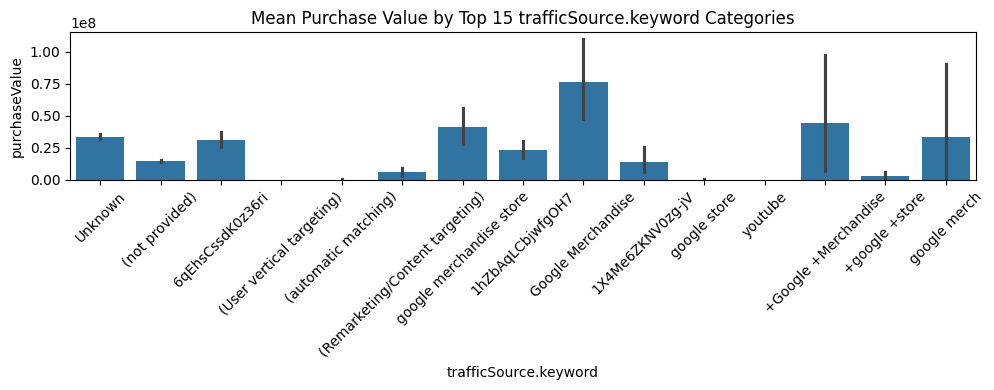

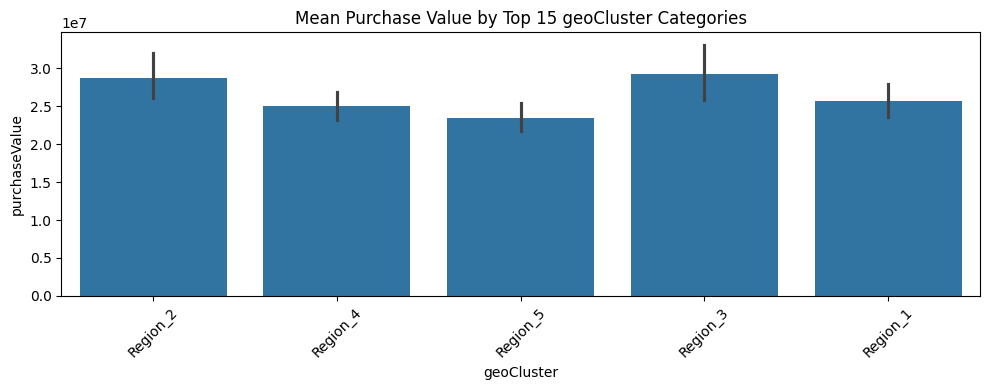

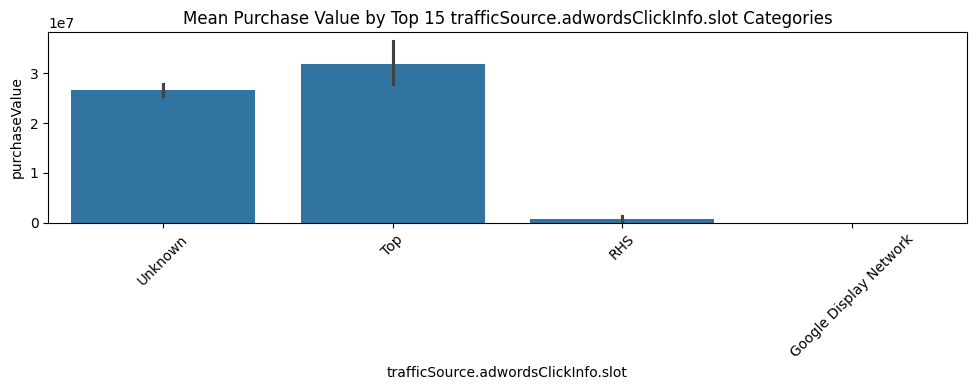

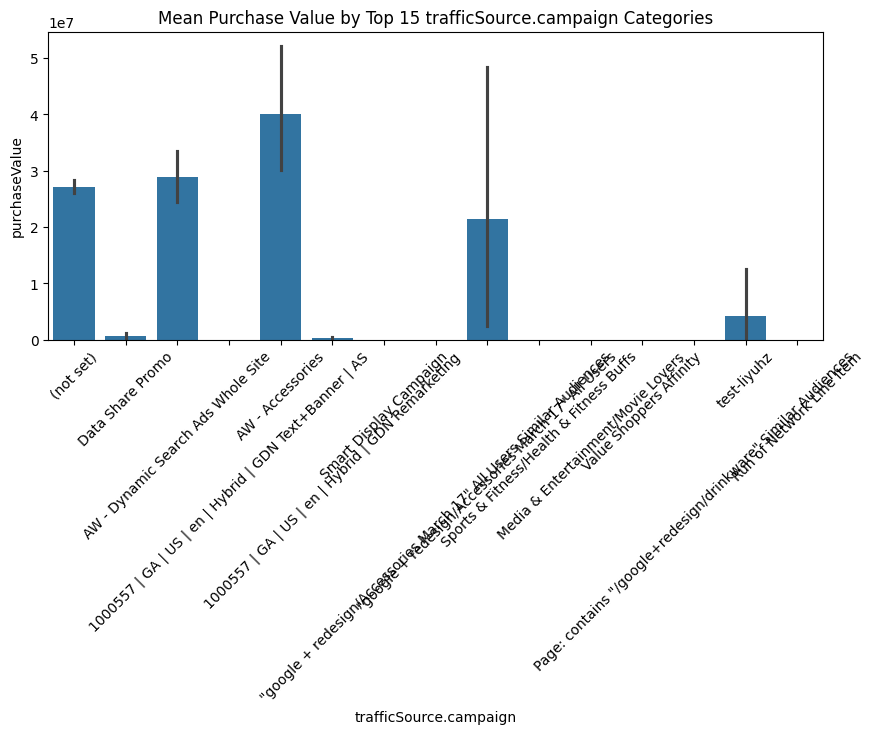

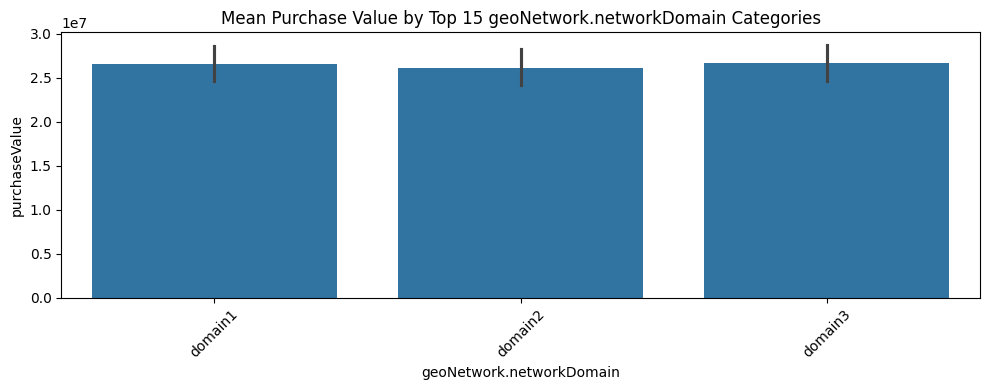

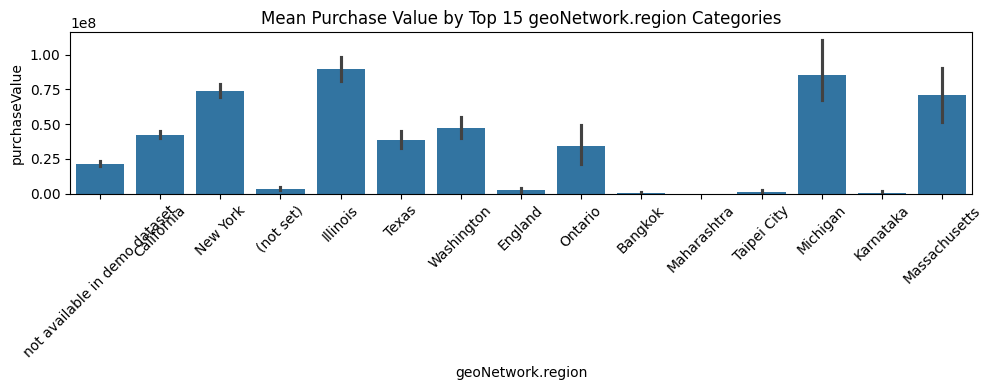

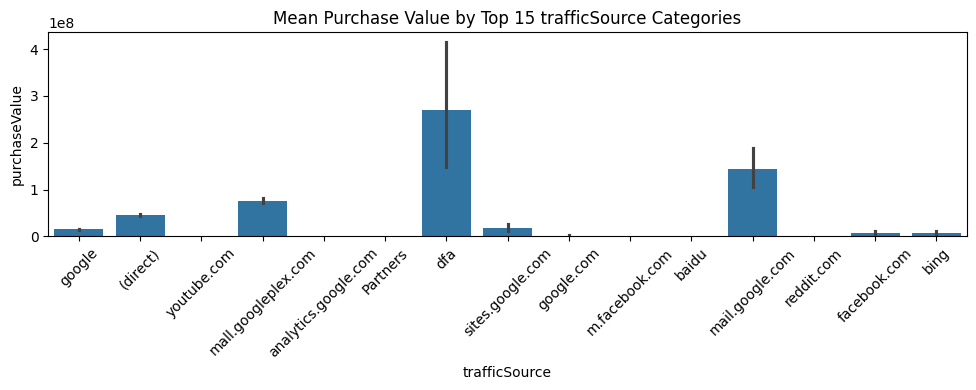

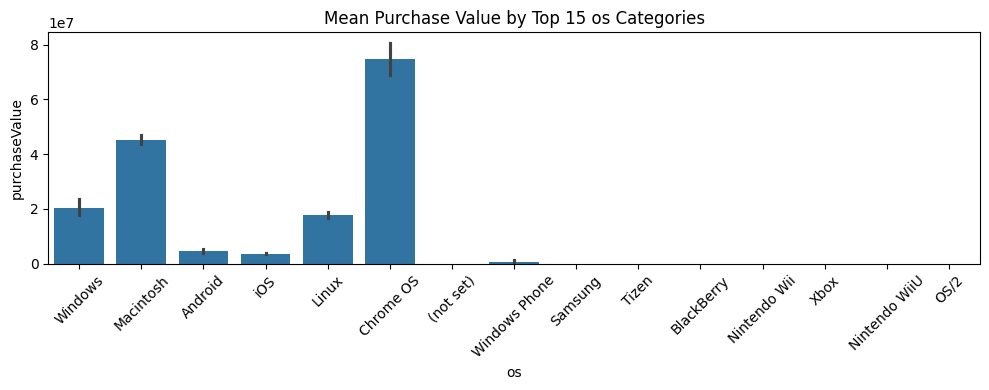

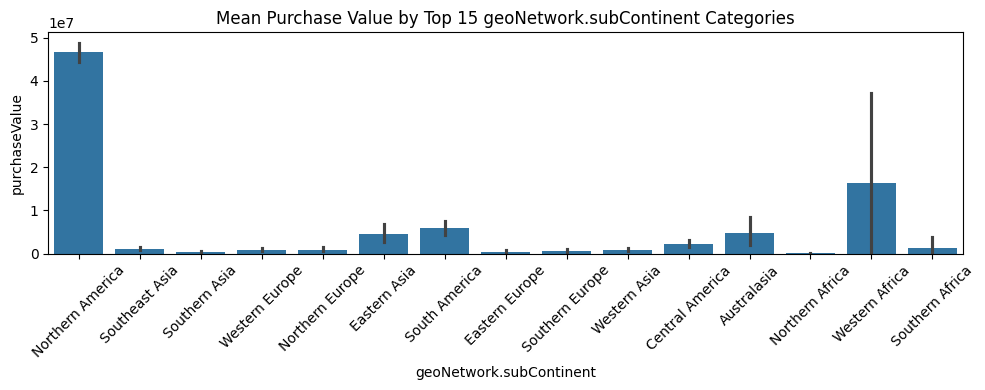

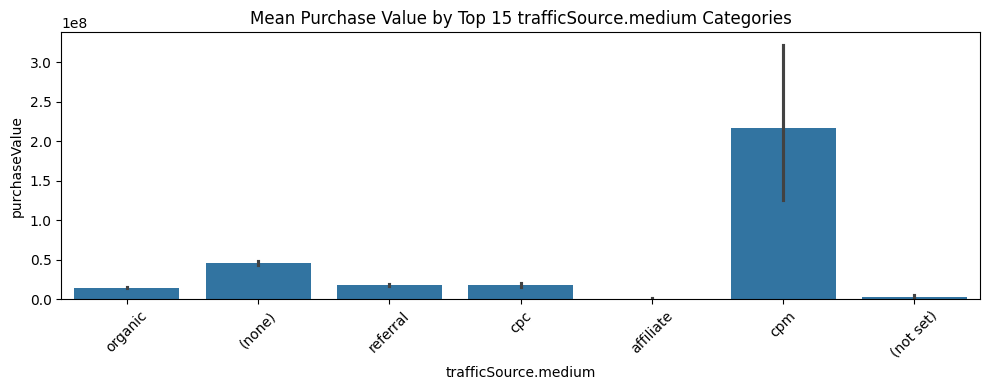

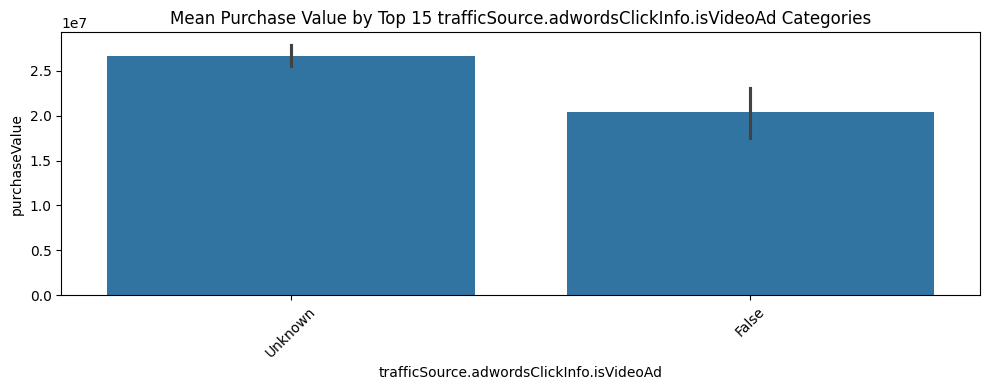

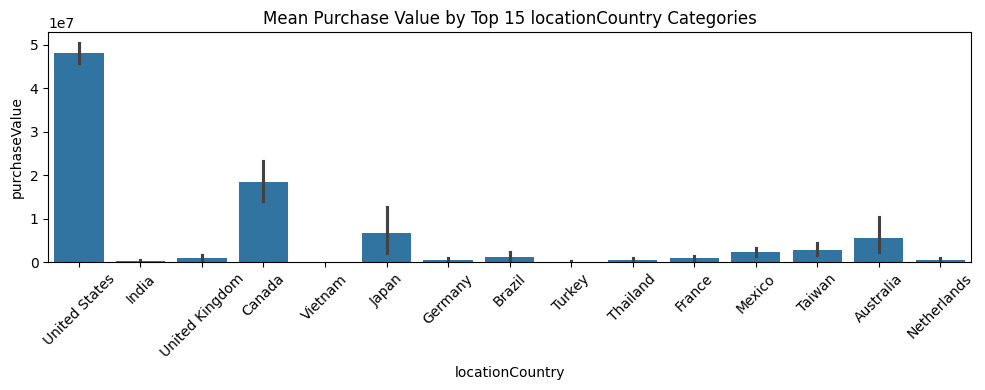

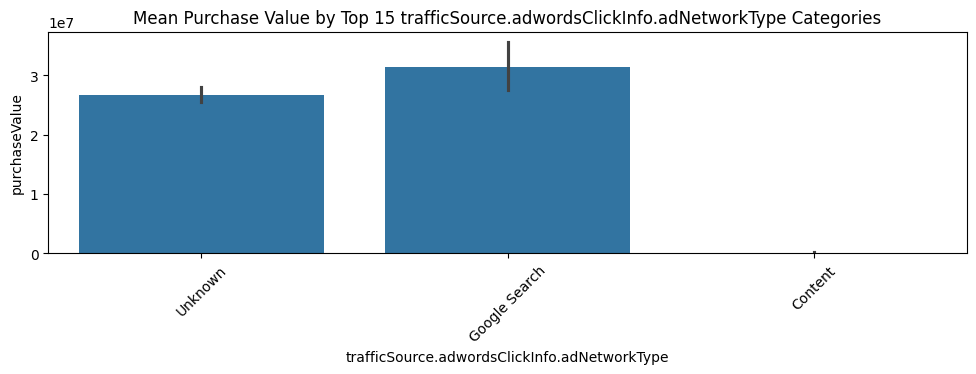

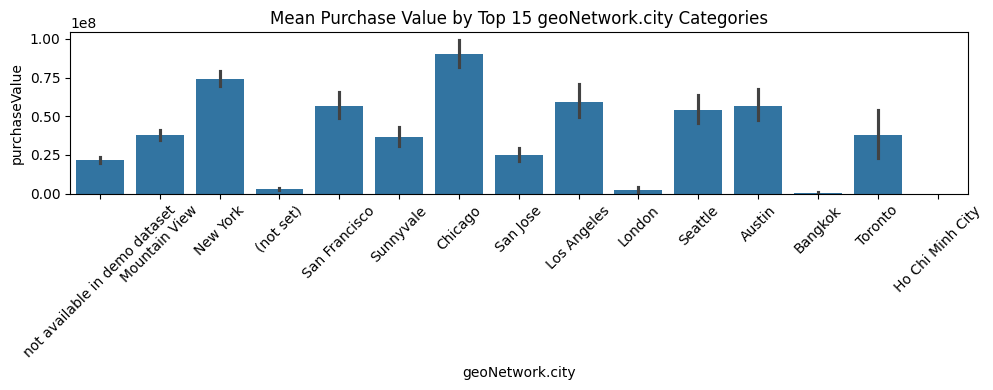

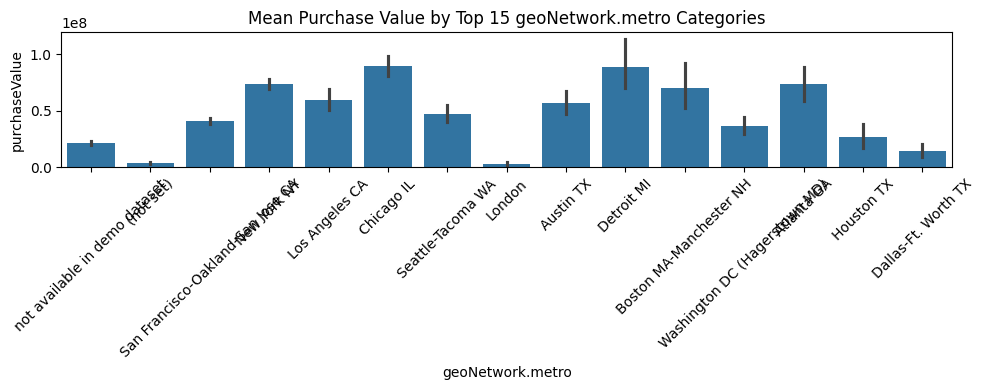

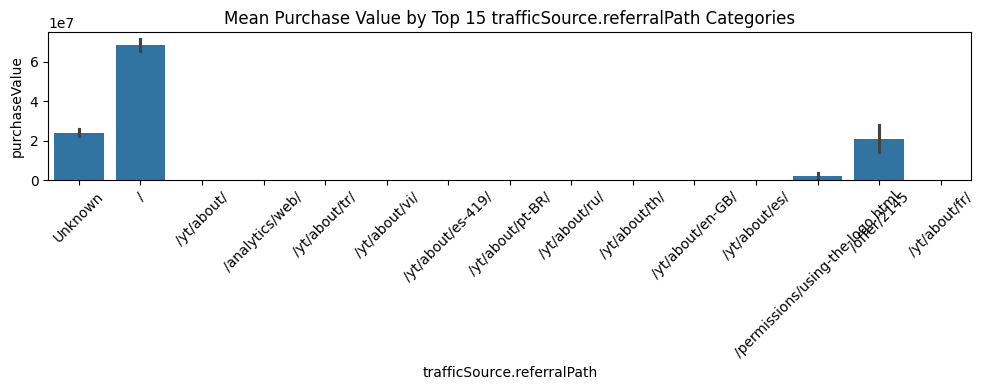

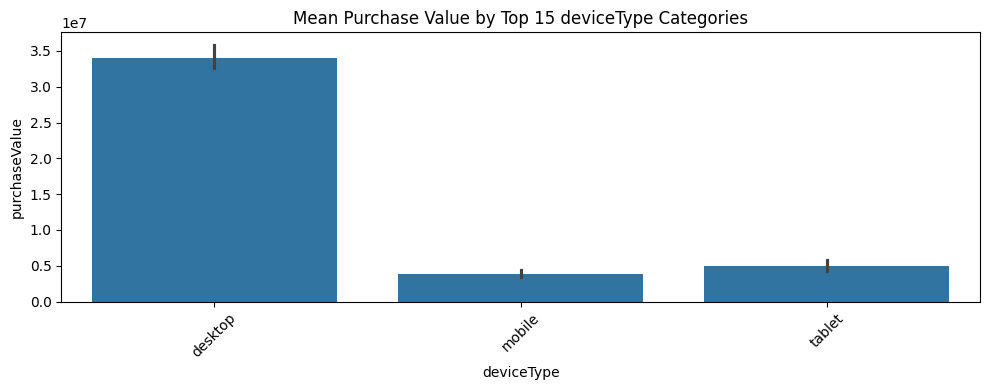

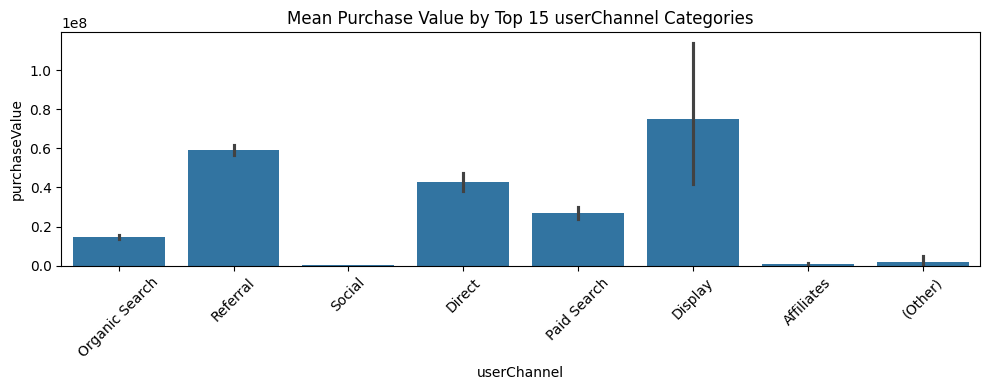

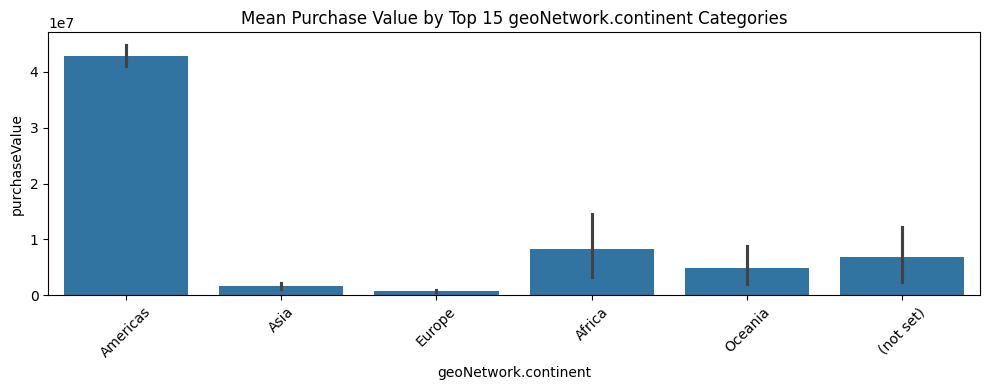

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = df.select_dtypes(include='object').columns
TOP_K = 15  
for col in cat_cols:
    top_k = df[col].value_counts().nlargest(TOP_K).index
    filtered_df = df[df[col].isin(top_k)]
    plt.figure(figsize=(10, 4))
    sns.barplot(data=filtered_df, x=col, y='purchaseValue', estimator='mean', order=top_k)
    plt.xticks(rotation=45)
    plt.title(f"Mean Purchase Value by Top {TOP_K} {col} Categories")
    plt.tight_layout()
    plt.show()


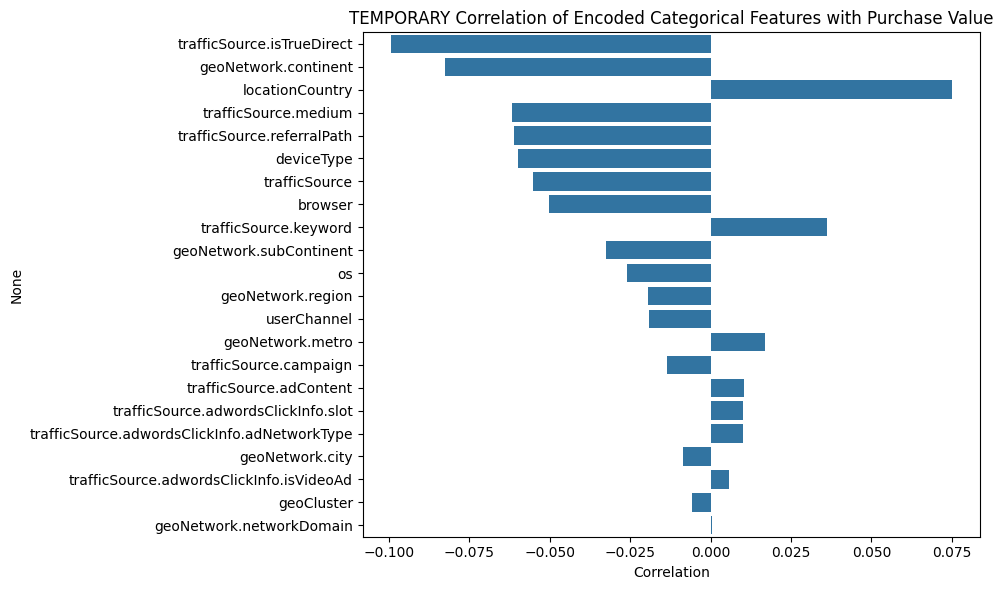

In [44]:
temp_df = df.copy()

# Step 1: Encode object columns temporarily
cat_cols = temp_df.select_dtypes(include='object').columns
le = LabelEncoder()

for col in cat_cols:
    temp_df[col] = le.fit_transform(temp_df[col].astype(str))

# Step 2: Correlation with purchaseValue
cat_corrs = temp_df[cat_cols].corrwith(temp_df['purchaseValue']).sort_values(key=abs, ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cat_corrs.values, y=cat_corrs.index)
plt.title("TEMPORARY Correlation of Encoded Categorical Features with Purchase Value")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


In [45]:
high_corr_numeric = ['totalHits', 'pageViews', 'sessionNumber']
print("Highly correlated numeric features:", high_corr_numeric)


Highly correlated numeric features: ['totalHits', 'pageViews', 'sessionNumber']


In [46]:
high_corr_categorical = [
    'trafficSource.isTrueDirect',
    'geoNetwork.continent',
    'locationCountry',
    'trafficSource.medium',
    'trafficSource.referralPath',
    'deviceType',
    'trafficSource',
    'browser',
    'trafficSource.keyword'
]
print("Highly correlated categorical features:", high_corr_categorical)


Highly correlated categorical features: ['trafficSource.isTrueDirect', 'geoNetwork.continent', 'locationCountry', 'trafficSource.medium', 'trafficSource.referralPath', 'deviceType', 'trafficSource', 'browser', 'trafficSource.keyword']


In [47]:
X = df.drop(columns=['purchaseValue'])  
y = df['purchaseValue']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (92629, 32)
Validation shape: (23158, 32)


In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from category_encoders import TargetEncoder

import xgboost as xgb
import pandas as pd

# --- Step 1: Identify Columns ---
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# --- Step 2: Handle NA + Cast types ---
X_train[cat_cols] = X_train[cat_cols].fillna("Unknown").astype(str)
X_val[cat_cols] = X_val[cat_cols].fillna("Unknown").astype(str)

# --- Step 3: Preprocessing Pipeline ---
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', TargetEncoder(), cat_cols)
])


# --- Step 4: Full Pipeline with XGBoost ---
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=2000,
        learning_rate=0.0125,
        max_depth=16,
        subsample=0.875,
        colsample_bytree=0.875,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    ))
])

# --- Step 5: Fit the Model ---
print("⏳ Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)



⏳ Training XGBoost...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:

X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.2, random_state=52)

print("Train shape:", X_train2.shape)
print("Validation shape:", X_val2.shape)

Train shape: (92629, 32)
Validation shape: (23158, 32)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from category_encoders import TargetEncoder

import xgboost as xgb
import pandas as pd

# --- Step 1: Identify Columns ---
cat_cols = X_train2.select_dtypes(include='object').columns.tolist()
num_cols = X_train2.select_dtypes(include=['int64', 'float64']).columns.tolist()

# --- Step 2: Handle NA + Cast types ---
X_train2[cat_cols] = X_train2[cat_cols].fillna("Unknown").astype(str)
X_val2[cat_cols] = X_val2[cat_cols].fillna("Unknown").astype(str)

# --- Step 3: Preprocessing Pipeline ---
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', TargetEncoder(), cat_cols)
])


# --- Step 4: Full Pipeline with XGBoost ---
xgb_pipeline2 = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=2000,
        learning_rate=0.0125,
        max_depth=16,
        subsample=0.875,
        colsample_bytree=0.875,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    ))
])

# --- Step 5: Fit the Model ---
print("⏳ Training XGBoost...")
xgb_pipeline2.fit(X_train2, y_train2)



⏳ Training XGBoost...


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['userId', 'gclIdPresent',
                                                   'sessionNumber', 'sessionId',
                                                   'trafficSource.adwordsClickInfo.page',
                                                   'pageViews', 'date',
                                                   'totalHits',
                                                   'sessionStart']),
                                                 ('cat', TargetEncoder(),
                                                  ['trafficSource.isTrueDirect',
                                                   'browser',
                                                   'trafficSource.adContent',
                                                   'trafficSource.keyword',
                                                   'geoCluster',
                                                   '...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.0125, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=16,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=2000, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
y_pred = xgb_pipeline.predict(X_val)


mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\n XGBoost Performance ")
print(f"MAE = {mae:.2f}")
print(f"R²  = {r2:.4f}")


 XGBoost Performance 
MAE = 19759900.46
R²  = 0.3205


In [ ]:
y_pred2 = xgb_pipeline2.predict(X_val2)


mae = mean_absolute_error(y_val2, y_pred2)
r2 = r2_score(y_val2, y_pred2)

print("\n XGBoost Performance ")
print(f"MAE = {mae:.2f}")
print(f"R²  = {r2:.4f}")


 XGBoost Performance 
MAE = 19389049.81
R²  = 0.6153


In [ ]:
# --- Step 7: Prepare test_df ---
test_df[cat_cols] = test_df[cat_cols].fillna("Unknown").astype(str)

# --- Step 8: Predict using trained pipeline ---
print("🧪 Predicting on test set...")
test_preds = xgb_pipeline2.predict(test_df)
test_preds2 = xgb_pipeline.predict(test_df)
test_preds = (test_preds*0.30 + test_preds2*0.70)/0.90

# Optional: Clip negative predictions if not allowed
test_preds = test_preds.clip(min=0)


# --- Step 9: Create Submission File ---
submission = pd.DataFrame({
    'id': test_df.index,  # Replace with the correct ID column name if different
    'purchaseValue': test_preds
})

# --- Step 10: Save as CSV ---
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as 'submission.csv'")


🧪 Predicting on test set...
✅ Submission file saved as 'submission.csv'


In [ ]:
submission

,id,purchaseValue
0,0,3.454616e+07
1,1,1.824329e+06
2,2,9.879195e+04
3,3,6.857735e+05
4,4,7.157325e+04
...,...,...
29001,29001,2.352854e+05
29002,29002,1.721996e+08
29003,29003,5.362023e+07
29004,29004,0.000000e+00
